# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data_r1 = pd.read_csv('geo_data_0.csv')
data_r2 = pd.read_csv('geo_data_1.csv')
data_r3 = pd.read_csv('geo_data_2.csv')
data_r1['reg']=1
data_r2['reg']=2
data_r3['reg']=3
data = pd.concat([data_r1, data_r2, data_r3]).reset_index(drop=True)
data['id'].nunique()

299951

In [3]:
data[data['id'].duplicated()].id.values

array(['HZww2', 'bxg6G', 'A5aEY', 'QcMuo', '74z30', 'AGS9W', 'Tdehs',
       'fiKDv', 'TtcGQ', 'bsk9y', 'CXJ2r', 'LHZR0', 'pGQRI', 'gnA83',
       'mpZhE', 'L1Fdm', 'it2OW', 'bfPNe', 'wt4Uk', '5ltQ6', 'Q64YW',
       'Y2udP', 'g3RRG', 'Mp3uM', 'uSye4', 'LhkAh', 'i2csb', 'g2I86',
       'TXPOv', '2tyMi', 'wqgPo', 'H2jd8', 'uMqiK', 'xCHr8', 'scFN4',
       'lFHA5', 'VF7Jo', 'rAJA6', 'KUPhW', 'Suyut', 'D8TNs', '5ssQt',
       'kpKGs', 'TAqwC', 'eVdPR', 'tgOl6', 'G6k8A', 'Vcm5J', 'PyNp5'],
      dtype=object)

In [4]:
data[data.id.isin(['HZww2', 'bxg6G', 'A5aEY', 'QcMuo', '74z30', 'AGS9W', 'Tdehs',
       'fiKDv', 'TtcGQ', 'bsk9y', 'CXJ2r', 'LHZR0', 'pGQRI', 'gnA83',
       'mpZhE', 'L1Fdm', 'it2OW', 'bfPNe', 'wt4Uk', '5ltQ6', 'Q64YW',
       'Y2udP', 'g3RRG', 'Mp3uM', 'uSye4', 'LhkAh', 'i2csb', 'g2I86',
       'TXPOv', '2tyMi', 'wqgPo', 'H2jd8', 'uMqiK', 'xCHr8', 'scFN4',
       'lFHA5', 'VF7Jo', 'rAJA6', 'KUPhW', 'Suyut', 'D8TNs', '5ssQt',
       'kpKGs', 'TAqwC', 'eVdPR', 'tgOl6', 'G6k8A', 'Vcm5J', 'PyNp5'])].sort_values(by='id')

id         f0         f1        f2     product  reg
227380  2tyMi  -1.789602  -1.359044 -4.840745  145.901447    3
45429   2tyMi   0.576679  -0.411140 -3.725859   69.292672    1
105849  5ltQ6  -3.435401 -12.296043  1.999796   57.085625    2
184461  5ltQ6  18.213839   2.191999  3.993869  107.813044    2
272896  5ssQt  -0.651825   0.782415  2.690636  120.108761    3
...       ...        ...        ...       ...         ...  ...
227885  wqgPo   0.052461   1.424025  0.085541   10.686576    3
182873  wt4Uk  10.259972  -9.376355  4.994297  134.766305    2
147591  wt4Uk  -9.091098  -8.109279 -0.002314    3.179103    2
243233  xCHr8  -0.847066   2.101796  5.597130  184.388641    3
228039  xCHr8   1.633027   0.368135 -2.378367    6.120525    3

[98 rows x 6 columns]

_Видим, что идентификаторы скважин дублируются, даже для скважинами из разных регионов, но сами записи разные. Надеюсь, что они не пригодятся. Просто будем помнить об этом при расчетах._

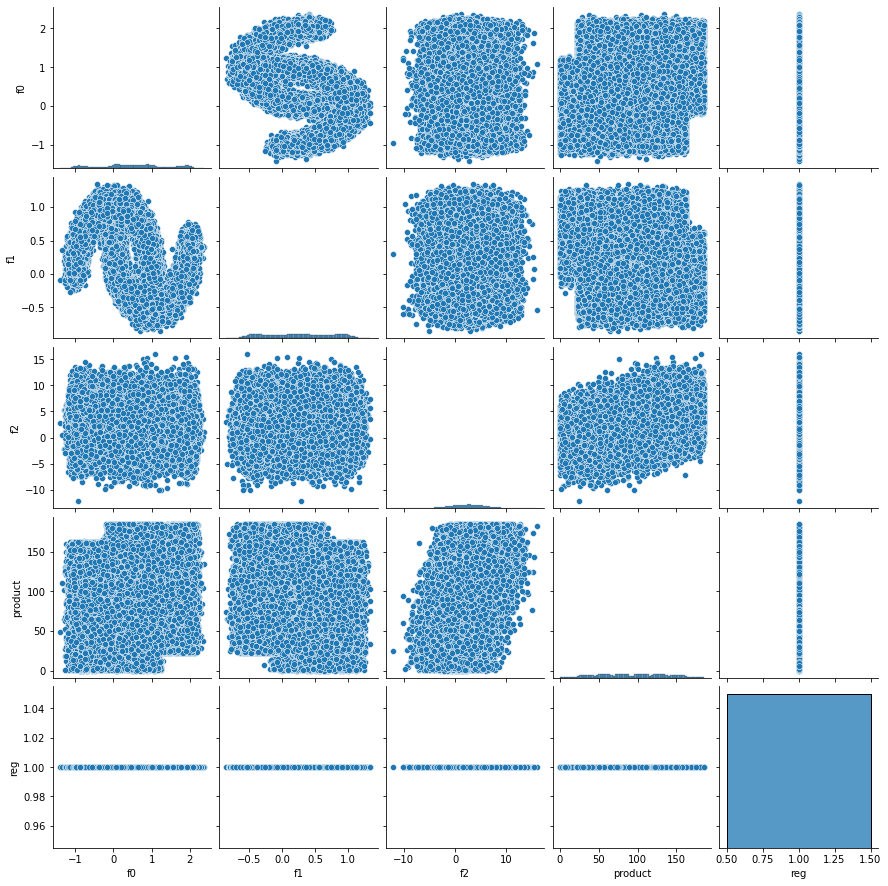

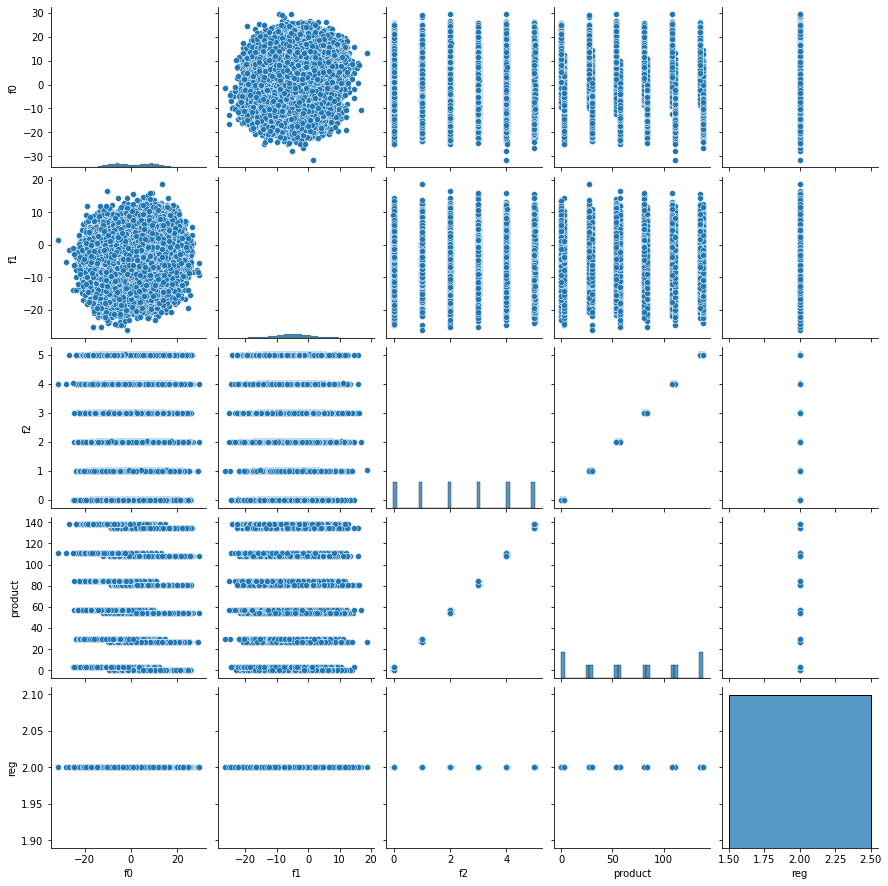

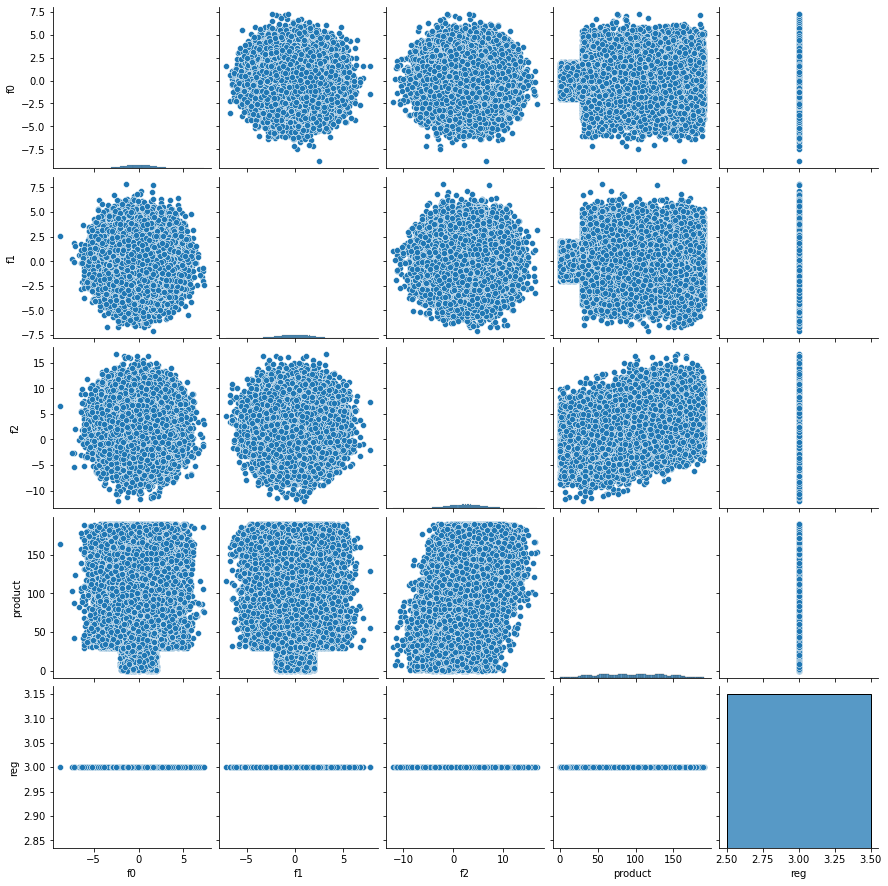

In [5]:
for reg in range(1,4):
    df = data[data.reg == reg]
    sns.pairplot(df)
    plt.show

_Синтетическая природа данных бросается в глаза._

## Обучение и проверка модели

In [6]:
# Функция предсказывает запасы по всем скважинам из df
def check_region(df):
    target = df['product']
    features = df.iloc[:,:4]
    X_train, X_test, y_train, y_test = train_test_split(
             features, target, test_size=0.25, random_state=42)
    boreholes = X_test.iloc[:,0]
    X_train = X_train.iloc[:,1:]
    X_test = X_test.iloc[:,1:]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LinearRegression().fit(X_train, y_train)
    predicted = model.predict(X_test)
    rmse = mean_squared_error(y_test, predicted) ** .5
    prediction_ = pd.concat([boreholes.reset_index(drop=True), 
                             pd.DataFrame(predicted), 
                             y_test.reset_index(drop=True)], axis=1, ignore_index=True)
    return prediction_, rmse

In [7]:
# Формируем таблицу с предсказаниями по всем регионам
predictions = pd.DataFrame()
mean_pen_reg = {}
for reg in range(1,4):
    print(f'Регион{reg}:')
    df = data[data.reg == reg]
    prediction_, rmse = check_region(df)
    prediction_['region'] = reg
    predictions = pd.concat([predictions, prediction_])
    print(f'Средний запас скважины: {predictions[predictions.region == reg][1].mean()} RMSE:{rmse}')
predictions.columns = ['borehole', 'prod_pred', 'prod_real', 'region']
predictions

Регион1:
Средний запас скважины: 92.39879990657812 RMSE:37.75660035026169
Регион2:
Средний запас скважины: 68.71287803913759 RMSE:0.890280100102884
Регион3:
Средний запас скважины: 94.7710238776599 RMSE:40.145872311342174


borehole   prod_pred   prod_real  region
0        7C6bA  101.901017  122.073350       1
1        dVxsn   78.217774   48.738540       1
2        1Gm3l  115.266901  131.338088       1
3        Nzg1t  105.618618   88.327757       1
4        Z7b4F   97.980185   36.959266       1
...        ...         ...         ...     ...
24995    hMnQH  102.764169   40.797226       3
24996    KGq37   93.431823   87.144239       3
24997    CKCjb   64.098390   52.039812       3
24998    ANcQx   83.764135  136.961454       3
24999    AarNF   86.558644  109.173206       3

[75000 rows x 4 columns]

In [8]:
predictions['dif_abs'] = np.abs(predictions['prod_pred'] - predictions['prod_real'])
predictions['dif'] = (predictions['prod_pred'] - predictions['prod_real'])

print(f'Отклонения предсказаний по запасам:') 
for i in range(1, 4):
    a = predictions[predictions['region'] == i]['dif'].sum()
    b = predictions[predictions['region'] == i]['dif_abs'].sum()
    print(f'      Регион{i}:   {round(a, 3)} абсолютные {round(b, 3)}')
    

Отклонения предсказаний по запасам:
      Регион1:   1821.088 абсолютные 776192.038
      Регион2:   -312.568 абсолютные 17925.299
      Регион3:   -9499.38 абсолютные 822423.965


_Природа данных такова, что качество модели на втором регионе значительно превосходит модели в других регионах, но запасы в нем меньше, чем в других регионах._

## Подготовка к расчёту прибыли

In [9]:
BUDGET_PER_REGION = 10_000_000_000 
INCOM_PER_BARREL = 450_000
LOSS_PROBABILITY = .025
BUGET_PER_BOREHOLE = BUDGET_PER_REGION / 200
print(f'Достаточный обьем скважины: {BUGET_PER_BOREHOLE / INCOM_PER_BARREL}')

Достаточный обьем скважины: 111.11111111111111


_При таких вводных средние затраты на скважину составят 50 млн. рублей и достаточный запас скважины для безубыточности равен 111.1111 тыс. барелей. Что выше, чем средние запасы скважин по всем регионам. Придется выбирать скважины._

## Расчёт прибыли и рисков 

In [10]:
# Функция подсчета валового дохода по региону
def profit_of_region(df_region):
    return df_region['prod_real'].sum() * INCOM_PER_BARREL
# Обсчет прибыли по регионам по лучшим выборкам скважин
for reg in range(1, 4):
    data = predictions[predictions['region'] == reg].sort_values(by='prod_pred', ascending=False).head(200)
    print(f'''Регион{reg}
    Средние запасы на скважину: {round(data['prod_real'].mean(), 3)} тыс. барелей
    Расчетная прибыль:          {round((profit_of_region(data) - BUDGET_PER_REGION) / 1e6, 3)} млн. руб 
    ''')

Регион1
    Средние запасы на скважину: 148.435 тыс. барелей
    Расчетная прибыль:          3359.141 млн. руб 
    
Регион2
    Средние запасы на скважину: 137.945 тыс. барелей
    Расчетная прибыль:          2415.087 млн. руб 
    
Регион3
    Средние запасы на скважину: 139.984 тыс. барелей
    Расчетная прибыль:          2598.572 млн. руб 
    


_Для 200 лучших скважин запасы и ожидаемая прибыль выглядят весьма оптимистично._

In [11]:
#  Применяем bootstrap
state = np.random.RandomState(42)
for reg in range(1,4):
    data = predictions[predictions['region'] == reg]
    result = []
    for i in tqdm(range(1000)):
        smpls = data.sample(n=500, replace=True, random_state=state).sort_values(by='prod_pred', ascending=False).head(200)
        
        diff = profit_of_region(smpls) - BUDGET_PER_REGION
        result.append(diff)
    result = pd.Series(result)  
    print(f'''Регион{reg}
    Средняя прибыль:            {round(result.mean() / 1e6, 3)} млн. руб 
    Доверительный интервал 95%: {round(result.quantile(0.025) / 1e6, 3)} ÷ {round(result.quantile(0.975) / 1e6, 3)}
    Риск убытков:               {(result < 0).mean()}
    ''')


  0%|          | 0/1000 [00:00<?, ?it/s]

Регион1
    Средняя прибыль:            399.575 млн. руб 
    Доверительный интервал 95%: -110.468 ÷ 897.46
    Риск убытков:               0.06
    


  0%|          | 0/1000 [00:00<?, ?it/s]

Регион2
    Средняя прибыль:            452.577 млн. руб 
    Доверительный интервал 95%: 52.309 ÷ 830.146
    Риск убытков:               0.009
    


  0%|          | 0/1000 [00:00<?, ?it/s]

Регион3
    Средняя прибыль:            378.706 млн. руб 
    Доверительный интервал 95%: -127.779 ÷ 907.923
    Риск убытков:               0.075
    


_Первый и третий регионы не удовлетворяют критерию по риску безубыточности. С учетом качества модели и результатов бутстрепа я бы выбрал регион №2 для разработки. Готовьте людей и технику, мы идем бурить!_